In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
BATCH_SIZE = 60
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/EmotionDetection/validation",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2900 files belonging to 7 classes.


In [5]:
class_names = dataset.class_names
class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(60, 256, 256, 3)
[3 3 4 3 0 4 3 3 0 2 5 3 1 3 6 6 6 1 4 3 2 3 3 3 2 5 2 1 2 6 4 4 6 1 6 6 5
 6 6 4 0 2 0 2 6 3 3 0 0 6 3 3 4 0 6 2 3 6 3 0]


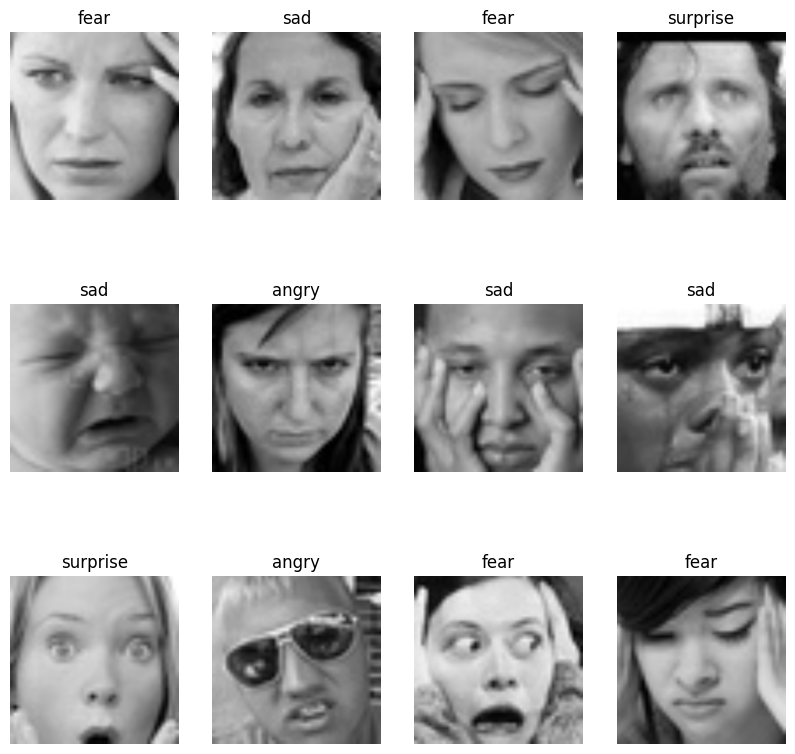

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
train_size = 0.8
len(dataset)*train_size

39.2

In [11]:
len(dataset)*60

2940

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(val_ds)

4

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
from tensorflow.keras import layers

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 7

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (60, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (60, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (60, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (60, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (60, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (60, 60, 60, 64)         

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
39/39 [==============================] - 539s 396ms/step - loss: 1.8839 - accuracy: 0.1926 - val_loss: 1.9095 - val_accuracy: 0.1833
Epoch 2/50
39/39 [==============================] - 4s 98ms/step - loss: 1.8696 - accuracy: 0.1874 - val_loss: 1.8796 - val_accuracy: 0.1833
Epoch 3/50
39/39 [==============================] - 4s 98ms/step - loss: 1.8623 - accuracy: 0.2030 - val_loss: 1.8615 - val_accuracy: 0.1917
Epoch 4/50
39/39 [==============================] - 4s 97ms/step - loss: 1.8632 - accuracy: 0.2078 - val_loss: 1.8743 - val_accuracy: 0.1708
Epoch 5/50
39/39 [==============================] - 4s 97ms/step - loss: 1.8437 - accuracy: 0.2222 - val_loss: 1.8281 - val_accuracy: 0.1958
Epoch 6/50
39/39 [==============================] - 4s 99ms/step - loss: 1.8310 - accuracy: 0.2170 - val_loss: 1.7896 - val_accuracy: 0.2417
Epoch 7/50
39/39 [==============================] - 4s 99ms/step - loss: 1.7928 - accuracy: 0.2717 - val_loss: 1.6930 - val_accuracy: 0.3500
Epoch 8/50

In [25]:
scores = model.evaluate(test_ds)

6/6 [==============================] - 13s 52ms/step - loss: 1.4644 - accuracy: 0.8583


In [26]:
scores

[1.4643816947937012, 0.8583333492279053]

first image to predict
actual label: angry
2/2 [==============================] - 2s 679ms/step
predicted label: angry


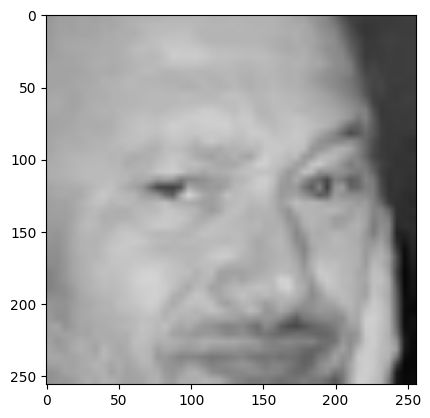

In [27]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


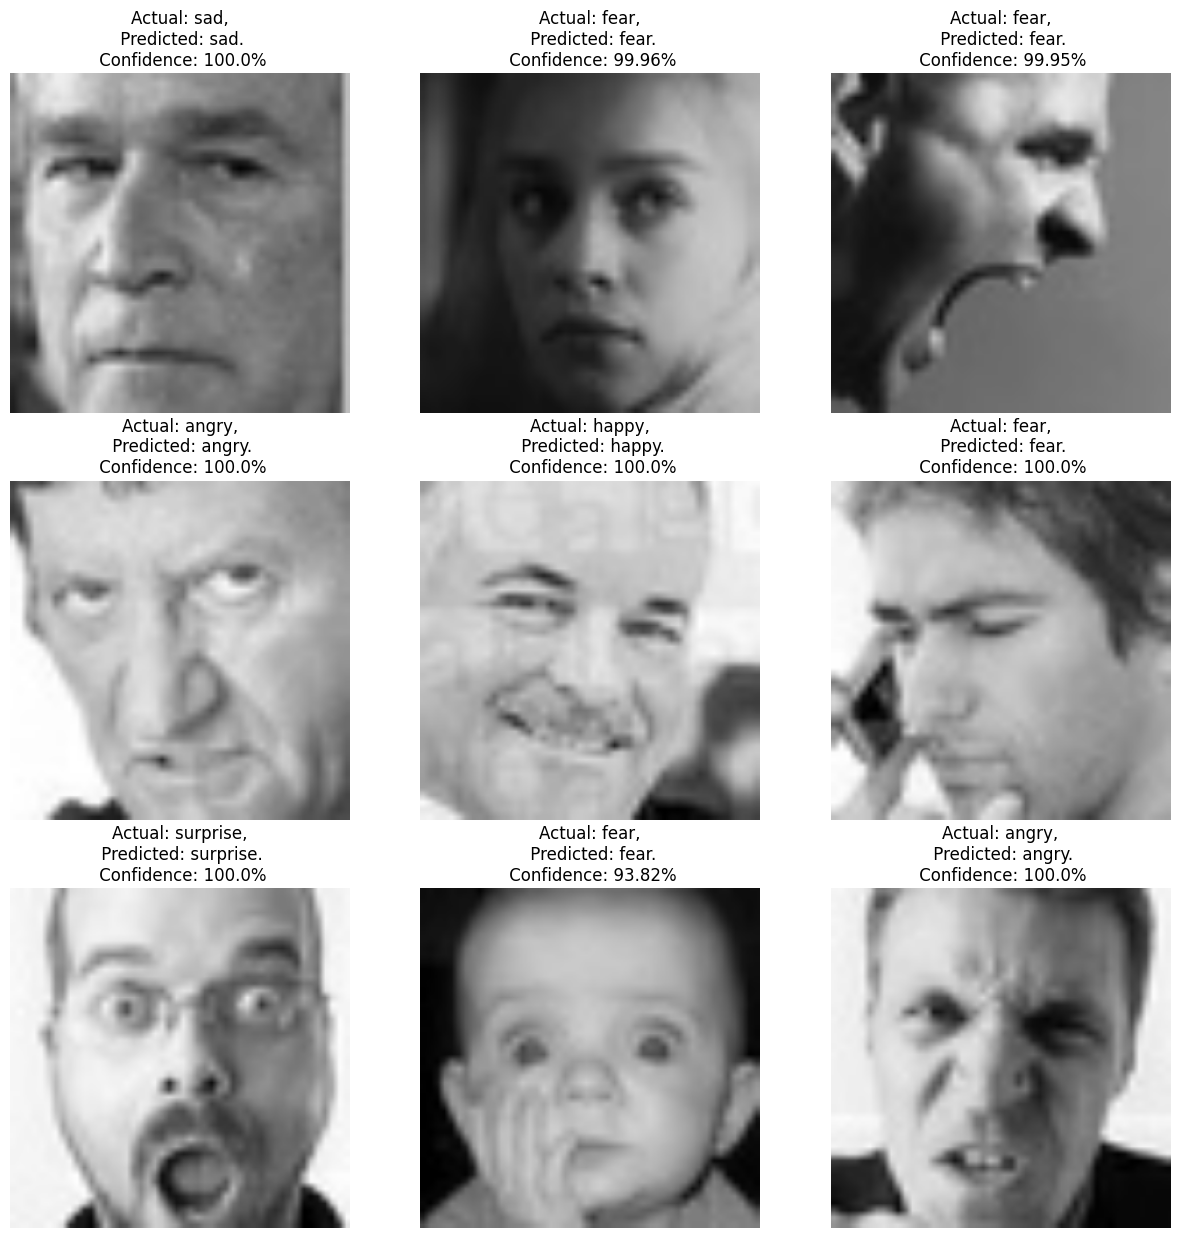

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [42]:
import os
model_version=max([int(i) for i in os.listdir("/content/drive/MyDrive/Colab Notebooks/EmotionDetection/models") + [0]])+1
model.save(f"/content/drive/MyDrive/Colab Notebooks/EmotionDetection/models/{model_version}")